In [15]:
from PIL import Image, ImageFilter, ImageOps
import numpy as np
from skimage import measure
import os
import sys
from sklearn.externals import joblib
from IPython.display import display, clear_output

# Constantes

In [49]:
tamanho_padrao = (40,80)

# Importar classificadores treinados

In [36]:
clf_svc = joblib.load('svc.pkl')
clf_nn = joblib.load('neuralnet.pkl')

# Funções

In [5]:
def F_BringNpImg(img):
    return np.array(img.getdata()).reshape(img.size[1], img.size[0])/255

In [6]:
def F_Rotacao(img, pontos):
    img_sup = img.crop((pontos[0],0,img.size[0]-pontos[1], 30))
    np_img = F_BringNpImg(img_sup)

    dif = np_img[:,-1].sum() - np_img[:,0].sum()
    sinal = -1 if dif > 0 else 1
    
    return np.arcsin(sinal*(dif/img_sup.size[1]))

In [7]:
def F_TestarRotacoes(img):
    aux = 0
    rotacao = 0
    for ii in range(100,int((img.size[0]-100)/2)):
        rotacao = F_Rotacao(img, (ii, ii))
        if np.absolute(rotacao) > np.absolute(aux):
            aux = rotacao

    return aux

In [8]:
def F_ReduzirAltura(img, criterio = 0.9):
    
    np_img = F_BringNpImg(img)
    
    sinal = 1
    for ii in range(0,100*sinal, sinal):
        if np_img[ii, 0:img.size[0]].mean() > criterio:
            break
    
    sinal = -1
    for jj in range(0,100*sinal, sinal):
        if np_img[jj, 0:img.size[0]].mean() > criterio:
            break
    
    return ii,jj

In [9]:
def F_ReduzirLargura(img, criterio = 0.9):
    
    np_img = F_BringNpImg(img)
    
    sinal = 1
    for ii in range(0,100*sinal, sinal):
        if np_img[0:img.size[1],ii].mean() > criterio:
            break
    
    sinal = -1
    for jj in range(0,100*sinal, sinal):
        if np_img[0:img.size[1],jj].mean() > criterio:
            break
    
    return ii,jj

In [10]:
def F_CortarImagem(img):

    Top, Bottom = F_ReduzirAltura(img, criterio=0.9)
    Left, Right = F_ReduzirLargura(img, criterio=0.9)

    return img.crop((Left, Top, img.size[0] + Right, img.size[1] + Bottom))

In [11]:
def F_AumentarDensidade(img_crop, step_vert = 50, step_hor = 5):
    
    for jj in range(0, img_crop.size[1]):
        for ii in range(0, img_crop.size[0]):

            if img_crop.getpixel((ii,jj)) == 0:

                end = 0
                for kk in range(ii + 1, ii + 1 + step_hor):

                    if img_crop.getpixel((kk,jj)) == 0:
                        end = kk
                    elif kk + 1 == img_crop.size[0]:
                        break

                for ii in range(ii, end):
                    img_crop.putpixel((ii,jj),0)
    if step_vert != 0:
        for ii in range(0, img_crop.size[0]):
            for jj in range(0, img_crop.size[1]):

                if img_crop.getpixel((ii,jj)) == 0:

                    end = 0
                    for kk in range(jj + 1, jj + 1 + step_vert):

                        try:
                        #Uma exceção deve ocorrer quando chegar ao limite da imagem
                            if img_crop.getpixel((ii, kk)) == 0:
                                end = kk
                            elif kk + 1 == img_crop.size[1]:
                                break
                        except:
                            pass

                    for jj in range(jj, end):
                        img_crop.putpixel((ii,jj), 0)

    return img_crop

In [12]:
def F_VisualizarResultado(img, posicoes):
    
    img_aux = img.convert('RGB')

    #Criar visualização
    for count, posicao in enumerate(posicoes):
        try:
            for ii in range(0, 70):
                img_aux.putpixel((int(posicao[0]), ii),(255,0,0))
                img_aux.putpixel((int(posicao[1]), ii),(255,0,0))
        except:
            pass

    return img_aux

In [13]:
def F_DisplayContour(img, contours):
    # Display the image and plot all contours found
    plt.figure(figsize=(50,100))
    plt.imshow(img, interpolation='nearest')

    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=5)

    plt.axis('image')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [14]:
def F_RetificarPosicoes(posicoes, min_width = 10, max_width_1 = 42, max_width_2 = 64):
    posicao_filtrada = []
    for posicao in posicoes:
        diff_abs = posicao[1] - posicao[0]
        if diff_abs > max_width_2:
            posicao_filtrada.append((posicao[0], posicao[0] + diff_abs/3))
            posicao_filtrada.append((posicao[0] + diff_abs/3, posicao[0] + 2*(diff_abs/3)))
            posicao_filtrada.append((posicao[0] + 2*(diff_abs/3), posicao[1] ))
        elif diff_abs > max_width_1:
            posicao_filtrada.append((posicao[0], posicao[0] + diff_abs/2))
            posicao_filtrada.append((posicao[1] - diff_abs/2, posicao[1]))
        elif diff_abs > min_width:
            posicao_filtrada.append(posicao) 
            
    return posicao_filtrada

In [43]:
F_CalcDim = lambda dim: (int(dim/2),int(dim/2)) if dim%2 == 0 else ((dim//2)+1, dim//2)

In [52]:
def S_CortarImagens(img_crop,posicoes, filename):
    resultado = []
    for ii, posicao in enumerate(posicoes):
        img_pred = img_crop.crop((posicao[0],0,posicao[1], img_crop.size[1]))
        
        width, height = img_pred.size
        
        width = F_CalcDim(tamanho_padrao[0]-width)
        height = F_CalcDim(tamanho_padrao[1]-height)
        
        img_pred = ImageOps.expand(img_pred, border=(width[0],height[0],width[1],height[1]), fill=255)
        
        features = np.array(img_pred.getdata())/255
        resultado.append(clf_svc.predict(features.reshape(1,-1)))
    
    return resultado

In [91]:
def S_EncontrarDigits(path_name, filename):
    
    img = Image.open(path_name)
    img  = img.rotate(F_TestarRotacoes(img))
    
    display(img)

    img = F_CortarImagem(img)
    img_crop = img.crop((50, 500, img.size[0] - 300, img.size[1]-20))

    img_aux = F_AumentarDensidade(img_crop.copy(), step_hor=4)

    #Encontrar contornos
    contours = measure.find_contours(img_aux, level= .99)

    #Guardar as posições
    posicoes = [(min(contour, key=lambda x:x[1])[1], max(contour, key=lambda x:x[1])[1]) for contour in contours]

    #Ordenar começando pela esquerda
    posicoes = sorted(posicoes, key= lambda x:x[1])[0:34]

    #São 34 posições onde estão os números e começo a contar pela esquerda
    #Se a distância entre a primeira marcaçãoe e a último for muito pequena, então preciso aumentar a densidade
    posicoes = F_RetificarPosicoes(posicoes)
    
    resultado = ''
    for count, ii in  enumerate(S_CortarImagens(img_crop,posicoes, filename)):
        if count == 0:
            resultado = str(ii[0])
        else:
            resultado = '_'.join([resultado,str(ii[0])])
    
    return resultado

In [92]:
pasta_imgs = 'Original_1'
generator_imgs = (('{}/{}'.format(pasta_imgs, ii),ii.split('.')[0]) for ii in os.listdir(pasta_imgs))

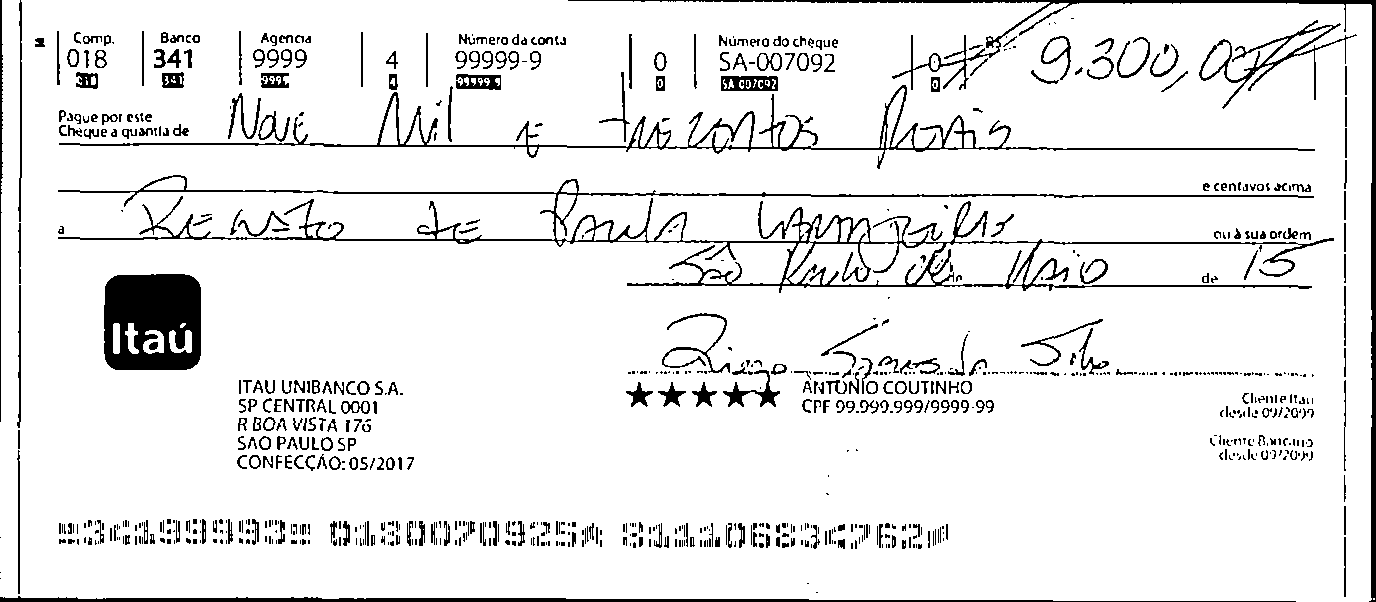

'10_3_4_1_9_9_9_9_3_10_0_1_8_0_0_7_0_9_2_5_11_8_1_1_1_0_6_8_3_4_7_6_2_12'

In [102]:
img_path, img_name = next(generator_imgs)
S_EncontrarDigits(img_path, img_name)

In [ ]:
pasta_imgs = 'Original_1'
generator_imgs = (('{}/{}'.format(pasta_imgs, ii),ii.split('.')[0]) for ii in os.listdir(pasta_imgs))
ii = 0
erro  ={}
for img_path, img_name in generator_imgs:
    try:
        ii = S_EncontrarDigits(img_path, img_name)
        sys.stdout.write('\r{}'.format(ii))
        ii+=1
    except:
        erro = dict(img_name= ii)